In [106]:
begin
	using Flux
	using Flux: onehot
	using Flux: gradient
	using Flux.Optimise: update!
	using Flux: onecold
	using CUDA
	using Transformers
	using Transformers.Basic 
    using Transformers.Datasets: batched
	using Flux: @functor
	using ..Transformers: Abstract3DTensor, Container, epsilon, batchedmul, batched_triu!
	using NNlib
	using Tullio
	using Plots
end

In [107]:
#=
Number of layers: 8
Number of heads: 8
Feed forward dimensions: 1024
d_model = 64
=#

In [108]:
#Labeling: vielleicht ändern

begin
	labels = map(string, 1:10)
	startsym = "11"
	endsym = "12"
	unksym = "0"
	labels = [unksym, startsym, endsym, labels...]
	vocab = Vocabulary(labels, unksym)
end


Vocabulary{String}(13, unk=0)

In [109]:
#function for generate training datas 

#nichts ändern
sample_data() = (d = map(string, rand(1:10, 10)); (d,d))

sample_data (generic function with 1 method)

In [110]:
#nichts ändern, generieren 10 string token, nutze 1-10

sample_data()

(["2", "3", "5", "9", "6", "3", "4", "9", "3", "1"], ["2", "3", "5", "9", "6", "3", "4", "9", "3", "1"])

In [111]:
#function for adding start & end symbol

preprocess(x) = [startsym, x..., endsym]

preprocess (generic function with 1 method)

In [112]:
begin
    @show sample_ex = preprocess.(sample_data())
    @show encoded_sample_ex = vocab(sample_ex[1]) #use Vocabulary to encode the training data, +3
    end

sample_ex = preprocess.(sample_data()) = (["11", "7", "7", "4", "6", "8", "1", "4", "8", "3", "5", "12"], ["11", "7", "7", "4", "6", "8", "1", "4", "8", "3", "5", "12"])
encoded_sample_ex = vocab(sample_ex[1]) = [2, 10, 10, 7, 9, 11, 4, 7, 11, 6, 8, 3]


12-element Vector{Int64}:
  2
 10
 10
  7
  9
 11
  4
  7
 11
  6
  8
  3

In [113]:
sample = preprocess.(sample_data())

(["11", "4", "3", "5", "9", "3", "8", "6", "9", "8", "1", "12"], ["11", "4", "3", "5", "9", "3", "8", "6", "9", "8", "1", "12"])

In [114]:
encoded_sample = vocab(sample[1])

12-element Vector{Int64}:
  2
  7
  6
  8
 12
  6
 11
  9
 12
 11
  4
  3

In [115]:
#define a Word embedding layer which turn word index to word vector

embed = Embed(128, length(vocab)) |> gpu

Embed(128)

In [116]:
#define a position embedding layer mentioned above

pe = PositionEmbedding(128) |> gpu

PositionEmbedding(128)

In [117]:
#wrapper for get embedding

function embedding(x)
    we = embed(x, inv(sqrt(128)))
    e = we .+ pe(we)
    return e
  end

embedding (generic function with 1 method)

In [118]:
abstract type AbstractAttention end

In [119]:
create_atten_mask1(T::Type, score::AbstractArray, ::Nothing, future) = create_atten_mask1(T, score, fill!(similar(score, size(score,1), size(score, 2), 1), one(T)), future)
function create_atten_mask1(T::Type, score::AbstractArray, _mask::AbstractArray, future::Bool=false)
  #size(mask) == (q, k, n, b)

  # ql, kl = size(mask)
  mask = copy(_mask)

  maskval = convert(T, -1e9)
  !future && batched_triu!(mask, 0)
  mask .= (1 .- mask) .* maskval
  return mask
end

create_atten_mask1 (generic function with 3 methods)

In [120]:
Flux.@nograd create_atten_mask1

In [121]:
struct MultiheadAttention_1{Q<:Dense, K<:Dense, V<:Dense, O<:Dense, DP<:Dropout} <: AbstractAttention
    head::Int
    future::Bool
    iqproj::Q
    ikproj::K
    ivproj::V
    oproj::O
    drop::DP
end

In [122]:
Flux.functor(mh::MultiheadAttention_1) = (mh.iqproj, mh.ikproj, mh.ivproj, mh.oproj), m -> MultiheadAttention_1(mh.head, mh.future, m..., mh.drop)

In [123]:
MultiheadAttention_1(head::Int,
                   is::Int,
                   hs::Int,
                   os::Int;
                   future::Bool=true, pdrop = 0.1) = MultiheadAttention_1(head,
                                                                        future,
                                                                        Dense(is, hs*head),
                                                                        Dense(is, hs*head),
                                                                        Dense(is, hs*head),
                                                                        Dense(hs*head, os),
                                                                        Dropout(pdrop),
                                                                        )


function Base.show(io::IO, mh::MultiheadAttention_1)
    hs = div(size(mh.iqproj.weight)[1], mh.head)
    is = size(mh.iqproj.weight)[end]
    os = size(mh.oproj.weight)[1]

    print(io, "MultiheadAttention(")
    print(io, "head=$(mh.head), ")
    print(io, "head_size=$(hs), ")
    print(io, "$(is)=>$(os)")

    if Flux.istraining()
        print(io, ", dropout=$(mh.drop.p))")
    else
        print(io, ")")
    end
end

In [124]:
function (mh::MultiheadAttention_1)(query::A1,
    key::A2,
    value::A3;
    mask=nothing) where {T,
                         A1 <: Abstract3DTensor{T},
                         A2 <: Abstract3DTensor{T},
                         A3 <: Abstract3DTensor{T}}
qs = size(query)
ks = size(key)
vs = size(value)

#size(ipq) == (h, q_seq_len, batch)
ipq = @toNd mh.iqproj(query)
ipk = @toNd mh.ikproj(key)
ipv = @toNd mh.ivproj(value)

h = size(ipq, 1)
hs = div(h, mh.head)

#size(ipq) == (hs, q_seq_len, head, batch)
ipq = permutedims(reshape(ipq, hs, mh.head, qs[2], qs[3]), [1, 3, 2, 4])
ipk = permutedims(reshape(ipk, hs, mh.head, ks[2], ks[3]), [1, 3, 2, 4])
ipv = permutedims(reshape(ipv, hs, mh.head, vs[2], vs[3]), [1, 3, 2, 4])

#size(ipq) == (hs, q_seq_len, head * batch)
ipq = reshape(ipq, hs, qs[2], :)
ipk = reshape(ipk, hs, ks[2], :)
ipv = reshape(ipv, hs, vs[2], :)

atten = attention1(ipq,ipk,ipv,
mask,
mh.future,
mh.drop,mh.head)

atten = permutedims(reshape(atten, hs, qs[2], mh.head, qs[3]), [1, 3, 2, 4]) #size(atten) == (hs, head, ql, b)
atten = reshape(atten, h, qs[2], qs[3]) #size(atten) == (h, ql, b)

out = @toNd mh.oproj(atten)
out #size(out) == (h, q_seq_len, batch)
end

function (mh::MultiheadAttention_1)(query::A1,
    key::A2,
    value::A3;
    mask=nothing) where {T,
                         A1 <: AbstractMatrix{T},
                         A2 <: AbstractMatrix{T},
                         A3 <: AbstractMatrix{T}}

# size(query) == (dims, seq_len)
ipq = mh.iqproj(query)
ipk = mh.ikproj(key)
ipv = mh.ivproj(value)

h = size(ipq)[1] #h == hs * head
hs = div(h, mh.head)

#size(hq) == (hs, seq_len, head)
hq = permutedims(reshape(ipq, hs, mh.head, :), [1, 3, 2])
hk = permutedims(reshape(ipk, hs, mh.head, :), [1, 3, 2])
hv = permutedims(reshape(ipv, hs, mh.head, :), [1, 3, 2])

atten = attention1(hq, hk, hv,
mask,
mh.future,
mh.drop,mh.head)

# size(atten) == (head*hs, seq_len)
atten = reshape(permutedims(atten, [1, 3, 2]), h, :)

mh.oproj(atten)
end

In [125]:
function apply_mask1(score, mask)
    s = size(score)
    ms = size(mask)
    bxn = s[end]
    b = ms[end]
    if bxn == b || b == 1
      return score .+ mask
    else
      return reshape(reshape(score, s[1:end-1]..., :, b) .+
                     reshape(mask, ms[1:end-1]..., 1, b), s)
    end
  end
  
  apply_mask1(score::AbstractArray{T}, ::Nothing, future) where T = future ? score : apply_mask1(score, create_atten_mask1(T, score, nothing, future))
  apply_mask1(score::AbstractArray{T}, mask, future) where T = apply_mask(score, create_atten_mask1(T, score, mask, future))

apply_mask1 (generic function with 3 methods)

In [126]:
# of type float (to allow for integer inputs)
function oftf(x, y)
    oftype(float(x), y)
end
function nelu(x, α=1)
    ifelse(x ≥ 0, float(x)+1, @fastmath oftf(x, α) * (exp(x) - 1)+1)
end

nelu (generic function with 2 methods)

In [127]:
x = embedding(encoded_sample)

128×12 Matrix{Float32}:
  0.492742    -0.488629    -0.970747   …  -0.00201693    0.958541
  0.797864     0.914671     0.360138       0.04893      -0.833579
  0.707373    -0.00888045  -0.866527      -1.07054      -0.530788
  0.658058     0.832071     0.603502       1.03786       0.438578
  0.67227      0.0931084   -0.529596      -0.224848     -0.817858
  0.433296     0.98964      0.850181   …   0.811493      1.10168
  0.800429     0.202702    -0.467546       0.74379       0.020749
  0.619195     0.982063     0.978251      -0.098461      0.466958
  0.866877     0.506233    -0.194401       1.04758       0.996295
  0.428513     0.866789     0.959077      -0.703733     -0.542097
  ⋮                                    ⋱   ⋮            
  0.0338934    0.0222793    0.190211       0.18267       0.0372519
  0.96112      1.07388      1.09958    …   1.05093       0.884489
  0.0601462    0.101847     0.0083902      0.000913331   0.00414561
  0.995797     1.01953      1.10602        0.930685      0.

In [128]:
function splitHeads(x, batch_size, head, depth)
    x = reshape(x, (batch_size, :, head, depth))
end

splitHeads (generic function with 1 method)

In [129]:
function padding_mask(seq)
    # Returns (batch, 1, seq_len, 1) tensor with 1's where the sequence is padded, 0 where it is not
    mask = isequal.(seq, 0)
    mask = mask[:,1,:,1]
    na = [CartesianIndex()]
return Float32.(mask[:,na,:,na])  # (batch, 1, seq_len, 1) m l j h  <- j gets masked
end

padding_mask (generic function with 1 method)

In [130]:
#hier anstatt softmax linear
function attention1(query::A1,
    key::A2,
    value::A3,
    mask, future::Bool,
    dropout, head) where {T,
                    A1 <: Abstract3DTensor{T},
                    A2 <: Abstract3DTensor{T},
                    A3 <: Abstract3DTensor{T}}
#size(query) == (dims, {q,k}_seq_len, batch) == size(key) == size(value)
#size(ipq) == (hs, q_seq_len, head * batch)
#size(score) == (k_seq_len, q_seq_len, batch)
#=
dk = size(key, 1)
score = batchedmul(key, query; transA = true) 
score = score ./ convert(T, sqrt(dk))

score = apply_mask1(score, mask, future)
score = softmax(score; dims=1)
dropout !== nothing && (score = dropout(score))
batchedmul(value, score) #size(return) == (dims, q_seq_len, batch)
=#
#size(query) == (batch, {q,k}_seq_len, dims) == size(key) == size(value)

query = permutedims(query,(3,2,1))
key = permutedims(key,(3,2,1))
value = permutedims(value,(3,2,1))

qs = size(query)
#batch = 8, seq_len = 12, d_model = 64
ks = size(key)
vs = size(value)

d_model = qs[3]

#depth = div(d_model, n_heads)
depth = div(d_model, head)   

# size(key) == (batch_size,  seq_len_k, num_heads, depth_k) (m,j,h,d)
query = nelu.(splitHeads(query, qs[1], head, depth))
key = nelu.(splitHeads(key, ks[1], head, depth))
value = splitHeads(value, vs[1], head, depth)

# size(k_v) == (batch_size, depth_k, depth_v, seq_len_v)
@tullio k_v[m,d,e,h] := key[m,j,h,d]*value[m,j,h,e]

#padmask = padding_mask(key)
#key = key .* padmask

k_reduced = dropdims(sum(key, dims=2), dims=2)

k_reduced = k_reduced .+ 1e-8

@tullio z_1[m,l,h] := query[m,l,h,d]*k_reduced[m,h,d]
# size(z) == (batch_size, num_heads, seq_len_q)
z = 1 ./ z_1 # ...

# size(output) == (batch_size,len_q, heads, depth_v)
@tullio output[m,l,h,e] := query[m,l,h,d]*k_v[m,d,e,h]*z[m,l,h]

#output = reshape(output, (qs[1], qs[2], mh.head*depth))
# size(output) == (batch_size,len_q, d_model)
output = reshape(output, (qs[1], :, head*depth))

output = permutedims(output,(3,2,1))
#(dims, q_seq_len, batch)
end

attention1 (generic function with 1 method)

In [131]:
abstract type AbstractTransformer end

In [132]:
struct PwFFN{Di<:Dense, Do<:Dense}
    din::Di
    dout::Do
end

@functor PwFFN


"just a wrapper for two dense layer."
function PwFFN(size::Int, h::Int, act = nelu)
    PwFFN(
    Dense(size, h, act),
    Dense(h, size)
)
end
function (pw::PwFFN)(x::AbstractMatrix)
  #size(x) == (dims, seq_len)
  pw.dout(pw.din(x))
end

function (pw::PwFFN)(x::A) where {T, N, A<:AbstractArray{T, N}}
  new_x = reshape(x, size(x, 1), :)
  y = pw(new_x)
  return reshape(y, Base.setindex(size(x), size(y, 1), 1))
end

In [133]:
struct Transformer1{MA<:MultiheadAttention_1, LA<:LayerNorm, P<:PwFFN, LP<:LayerNorm, DP<:Dropout} <: AbstractTransformer
    mh::MA
    mhn::LA
    pw::P
    pwn::LP
    drop::DP
end

@functor Transformer1


"""
    Transformer(size::Int, head::Int, ps::Int;
                future::Bool = true, act = relu, pdrop = 0.1)
    Transformer(size::Int, head::Int, hs::Int, ps::Int;
                future::Bool = true, act = relu, pdrop = 0.1)  

Transformer layer.

`size` is the input size. if `hs` is not specify, use `div(size, head)` as the hidden size of multi-head attention. 
`ps` is the hidden size & `act` is the activation function of the positionwise feedforward layer. 
When `future` is `false`, the k-th token can't see the j-th tokens where j > k. `pdrop` is the dropout rate.
"""

########
#ganze Funktion von Transformer ändern
########
function Transformer1(size::Int, head::Int, ps::Int; future::Bool = true, act = relu, pdrop = 0.1)  #relu vielleicht wieder auf elu ändern
    rem(size, head) != 0 && error("size not divisible by head")
    Transformer1(size, head, div(size, head), ps;future=future, act=act, pdrop=pdrop)
end

Transformer1(size::Int, head::Int, hs::Int, ps::Int; future::Bool = true, act = relu, pdrop = 0.1) = Transformer1(
    MultiheadAttention_1(head, size, hs, size; future=future, pdrop=pdrop),
    LayerNorm(size),
    PwFFN(size, ps, act),
    LayerNorm(size),
    Dropout(pdrop),     #braucht man das? vielleicht nicht
)

function (t::Transformer1)(x::A, mask=nothing) where {T, N, A<:AbstractArray{T, N}}
    dropout = t.drop
    a = t.mh(x, x, x; mask=mask)
    a = dropout(a)
    res_a = x + a
    res_a = t.mhn(res_a)
    pwffn = t.pw(res_a)
    pwffn = dropout(pwffn)
    res_pwffn = res_a + pwffn
    res_pwffn = t.pwn(res_pwffn)
    res_pwffn
end

function Base.show(io::IO, t::Transformer1) 
    hs = div(size(t.mh.iqproj.weight)[1], t.mh.head)
    h, ps = size(t.pw.dout.weight)

    print(io, "Transformer(")
    print(io, "head=$(t.mh.head), ")
    print(io, "head_size=$(hs), ")
    print(io, "pwffn_size=$(ps), ")
    print(io, "size=$(h)")
    if Flux.istraining()
        print(io, ", dropout=$(t.drop.p))")
    else
        print(io, ")")
    end
end

In [134]:
struct TransformerDecoder1{MA<:MultiheadAttention_1, LA<:LayerNorm,
        IMA<:MultiheadAttention_1, ILA<:LayerNorm,
        P<:PwFFN, LP<:LayerNorm, DP<:Dropout} <: AbstractTransformer
                mh::MA
                mhn::LA
                imh::IMA
                imhn::ILA
                pw::P
                pwn::LP
                drop::DP
end

@functor TransformerDecoder1

"""
TransformerDecoder(size::Int, head::Int, ps::Int; act = relu, pdrop = 0.1)
TransformerDecoder(size::Int, head::Int, hs::Int, ps::Int; act = relu, pdrop = 0.1)

TransformerDecoder layer. Decode the value from a Encoder.

`size` is the input size. if `hs` is not specify, use `div(size, head)` as the hidden size of multi-head attention. 
`ps` is the hidden size & `act` is the activation function of the positionwise feedforward layer. 
`pdrop` is the dropout rate.
"""
function TransformerDecoder1(size::Int, head::Int, ps::Int; act = relu, pdrop = 0.1)
rem(size, head) != 0 && error("size not divisible by head")
TransformerDecoder1(size, head, div(size, head), ps; act=act, pdrop=pdrop)
end

TransformerDecoder1(size::Int, head::Int, hs::Int, ps::Int; act = relu, pdrop = 0.1) = TransformerDecoder1(
MultiheadAttention_1(head, size, hs, size; future=false, pdrop=pdrop),
LayerNorm(size),
MultiheadAttention_1(head, size, hs, size; future=true, pdrop=pdrop), 
LayerNorm(size),
PwFFN(size, ps, act),
LayerNorm(size),
Dropout(pdrop),
)

function (td::TransformerDecoder1)(x::AbstractArray{T,N}, m, mask=nothing) where {T,N}
dropout = td.drop
a = td.mh(x,x,x)
a = dropout(a)
res_a = x + a
res_a = td.mhn(res_a)

ia = td.imh(res_a, m, m, mask=mask)
ia = dropout(ia)
res_ia = res_a + ia
res_ia = td.imhn(res_ia)

pwffn = td.pw(res_ia)
pwffn = dropout(pwffn)
res_pwffn = res_ia + pwffn
res_pwffn = td.pwn(res_pwffn)
res_pwffn
end

function Base.show(io::IO, td::TransformerDecoder1)
hs = div(size(td.imh.iqproj.weight)[1], td.imh.head)
h, ps = size(td.pw.dout.weight)

print(io, "TransformerDecoder(")
print(io, "head=$(td.mh.head), ")
print(io, "head_size=$(hs), ")
print(io, "pwffn_size=$(ps), ")
print(io, "size=$(h)")
if Flux.istraining()
print(io, ", dropout=$(td.drop.p))")
else
print(io, ")")
end
end

In [135]:
#define 2 layer of transformer

encode_t1 = Transformer1(128, 8, 64, 1024) |> gpu

Transformer(head=8, head_size=64, pwffn_size=1024, size=128)

In [136]:
encode_t2 = Transformer1(128, 8, 64, 1024) |> gpu

Transformer(head=8, head_size=64, pwffn_size=1024, size=128)

In [137]:
encode_t3 = Transformer1(128, 8, 64, 1024) |> gpu

Transformer(head=8, head_size=64, pwffn_size=1024, size=128)

In [138]:
encode_t4 = Transformer1(128, 8, 64, 1024) |> gpu


Transformer(head=8, head_size=64, pwffn_size=1024, size=128)

In [139]:
#define 2 layer of transformer decoder

decode_t1 = TransformerDecoder1(128, 8, 64, 1024, act=nelu) |> gpu

TransformerDecoder(head=8, head_size=64, pwffn_size=1024, size=128)

In [140]:
decode_t2 = TransformerDecoder1(128, 8, 64, 1024, act=nelu) |> gpu

TransformerDecoder(head=8, head_size=64, pwffn_size=1024, size=128)

In [141]:
decode_t3 = TransformerDecoder1(128, 8, 64, 1024, act=nelu) |> gpu

TransformerDecoder(head=8, head_size=64, pwffn_size=1024, size=128)

In [142]:
decode_t4 = TransformerDecoder1(128, 8, 64, 1024, act=nelu) |> gpu

TransformerDecoder(head=8, head_size=64, pwffn_size=1024, size=128)

In [143]:
#define the layer to get the final output probabilities

linear = Positionwise(Dense(128, length(vocab)), logsoftmax) |> gpu

Positionwise(Dense(128, 13), logsoftmax)

In [144]:
function encoder_forward(x)
    e = embedding(x)
    t1 = encode_t1(e)
    t2 = encode_t2(t1)
    t3 = encode_t2(t2)
    t4 = encode_t2(t3)
    return t2
end

encoder_forward (generic function with 1 method)

In [145]:
function decoder_forward(x, m)
    e = embedding(x)
    t1 = decode_t1(e, m)
    t2 = decode_t2(t1, m)
    t3 = decode_t3(t2, m)
    t4 = decode_t4(t3, m)
    p = linear(t4)
    return p
  end

decoder_forward (generic function with 1 method)

In [146]:
enc = encoder_forward(encoded_sample);

In [147]:
probs = decoder_forward(encoded_sample, enc);

In [148]:
function smooth(et)
    sm = fill!(similar(et, Float32), 1e-6/size(embed, 2))
    p = sm .* (1 .+ -et)
    label = p .+ et .* (1 - convert(Float32, 1e-6))
    label
end

smooth (generic function with 1 method)

In [149]:
Flux.@nograd smooth

In [150]:
#define loss function

function loss(x, y)
  label = onehot(vocab, y) #turn the index to one-hot encoding
  label = smooth(label) #perform label smoothing
  enc = encoder_forward(x)
  probs = decoder_forward(y, enc)
  # logcrossentropy used by Katharopoulos et al.
  l = logcrossentropy(label[:, 2:end, :], probs[:, 1:end-1, :])  
  return l
end

loss (generic function with 1 method)

In [151]:
#collect all the parameters

ps = params(embed, pe, encode_t1, encode_t2, encode_t3, encode_t4, decode_t1, decode_t2, decode_t3, decode_t4, linear);

In [152]:
opt = ADAM(1e-4) 

ADAM(0.0001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [153]:
#define training loop

function train!()
    @info "start training"
    losses =[]
    for i = 1:100
      data = batched([sample_data() for i = 1:32]) #create 32 random sample and batched
      x, y = preprocess.(data[1]), preprocess.(data[2])
      x, y = vocab(x), vocab(y) #encode the data
      x, y = todevice(x, y) #move to gpu
      grad = gradient(()->loss(x, y), ps)
      if i % 8 == 0
          l = loss(x, y)
          println("loss = $l")
      end
      update!(opt, ps, grad)
      push!(losses, loss(x,y))
    end
    return losses
  end

train! (generic function with 1 method)

In [154]:
train!()

┌ Info: start training
└ @ Main /Users/johannes/Documents/GitHub/DM2022-LinearTransformers/test/LinAt.ipynb:4


loss = 77.27944545593272


loss = 77.36003913373465


loss = 77.02405598345193


loss = 77.26442343650062


loss = 76.55338632593747


loss = 77.24687300611112


loss = 77.00559596883528


loss = 76.60372571424801


loss = 76.41622767912942


loss = 76.59964743826043


loss = 76.60988572604366


loss = 76.0232659249612


100-element Vector{Any}:
 83.18587183973669
 81.18755897122291
 80.38958137749137
 79.37800582695553
 79.48831111928693
 78.0060780582991
 77.63316942691814
 77.34876628357966
 77.70433247321913
 77.74275754125487
  ⋮
 75.68701454757876
 76.1077023955443
 75.95226129423138
 75.62009502228324
 75.77390346025973
 75.61004467579836
 75.91078513239958
 75.12017112688518
 75.8064769444809

In [155]:
losses = train!()

┌ Info: start training
└ @ Main /Users/johannes/Documents/GitHub/DM2022-LinearTransformers/test/LinAt.ipynb:4


loss = 75.3093925179901


loss = 73.17689909402075


loss = 70.7204534120818


loss = 67.35511613554571


loss = 62.08500335749254


loss = 59.62594237628173


loss = 60.34042382593122


loss = 58.181053394480045


loss = 57.78369393977786


loss = 56.50356088787359


loss = 57.16098963061923


loss = 56.31002735940224


100-element Vector{Any}:
 75.53522175179373
 75.56286947213374
 75.20936353938775
 75.12272364363933
 74.95403839886472
 75.46368657363344
 74.65482647729064
 74.75719941542837
 74.64050649860845
 74.40975265973626
  ⋮
 54.90250191436421
 56.005929305740125
 57.11505984001213
 57.937886385389724
 55.7269991281237
 56.96535296613942
 57.55589768231686
 57.4473819069275
 57.069995997453496

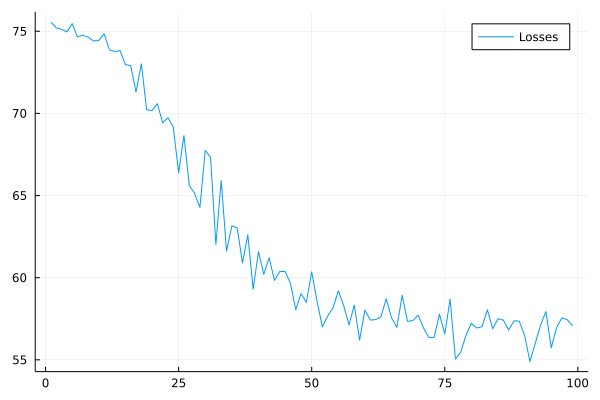

In [156]:
plot(vcat(losses[2:100]...), label="Losses")

In [157]:
#erst einmal so lassen, vielleicht einzelne Änderungen
function translate(x)
    ix = todevice(vocab(preprocess(x)))
    seq = [startsym]

    enc = encoder_forward(ix)

    len = length(ix)
    for i = 1:2len
        trg = todevice(vocab(seq))
        dec = decoder_forward(trg, enc)
        #move back to gpu due to argmax wrong result on CuArrays
        ntok = onecold(collect(dec), labels)
        push!(seq, ntok[end])
        ntok[end] == endsym && break
    end
  seq[2:end-1]
end

translate (generic function with 1 method)

In [158]:
translate(map(string, [5,5,6,6,1,12,3,4,6]))

10-element Vector{String}:
 "5"
 "5"
 "5"
 "5"
 "5"
 "5"
 "5"
 "5"
 "5"
 "5"